In [1]:
import pyqg
import json
import fsspec
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg_parameterization_benchmarks as ppb

In [2]:
# Datasets are hosted on globus as zarr files
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

highres = get_dataset("eddy/high_res").load()
lowres = get_dataset("eddy/low_res").load()

In [3]:
class HybridSymbolic(ppb.Parameterization):
    # The exact weights we learned in the paper
    weights = np.array([
        [ 1.4077349573135765e+07,  1.9300721349777748e+15,
          2.3311494532833229e+22,  1.1828024430000000e+09,
          1.1410567621344224e+17, -6.7029178551956909e+10,
          8.9901990193476257e+10],
        [ 5.196460289865505e+06,  7.031351150824246e+14,
          1.130130768679029e+11,  8.654265196250000e+08,
          7.496556547888773e+16, -8.300923156070618e+11,
          9.790139405295905e+11]
    ]).T[:,:,np.newaxis,np.newaxis]
    
    def terms(self, m):
        return ppb.FeatureExtractor(m)([
            'laplacian(advected(q))',
            'laplacian(laplacian(advected(q)))',
            'laplacian(laplacian(laplacian(advected(q))))',
            'laplacian(laplacian(q))',
            'laplacian(laplacian(laplacian(q)))',
            'advected(advected(ddx(laplacian(v))))',
            'advected(advected(ddy(laplacian(u))))'
        ])
    
    def predict(self, m):
        return dict(q_subgrid_forcing=(self.weights * self.terms(m)).sum(axis=0))
    
    @property
    def targets(self):
        return ['q_subgrid_forcing']
    
class BackscatterBiharmonic(ppb.Parameterization):
    def __init__(self, Cs, Cb): self._param = pyqg.BackscatterBiharmonic(Cs, Cb)
    def predict(self, m): return dict(q_subgrid_forcing=self._param(m))
    @property
    def targets(self): return ['q_subgrid_forcing']

class Smagorinsky(ppb.Parameterization):
    def __init__(self, Cs): self._param = pyqg.Smagorinsky(Cs)
    def predict(self, m):
        Su, Sv = self._param(m)
        return dict(u_subgrid_forcing=Su, v_subgrid_forcing=Sv)
    @property
    def targets(self): return ['u_subgrid_forcing','v_subgrid_forcing']

In [4]:
year = 24*60*60*360.
pyqg_config = dict(nx=64, dt=3600., tmax=10*year, tavestart=5*year, twrite=10000)

In [5]:
backscatter = BackscatterBiharmonic(np.sqrt(0.007), 1.2).run_online(**pyqg_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 9.23e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 4.48e-04, CFL: 0.036
INFO: Step: 30000, Time: 1.08e+08, KE: 5.32e-04, CFL: 0.046
INFO: Step: 40000, Time: 1.44e+08, KE: 5.96e-04, CFL: 0.048
INFO: Step: 50000, Time: 1.80e+08, KE: 6.39e-04, CFL: 0.050
INFO: Step: 60000, Time: 2.16e+08, KE: 5.66e-04, CFL: 0.054
INFO: Step: 70000, Time: 2.52e+08, KE: 5.99e-04, CFL: 0.052
INFO: Step: 80000, Time: 2.88e+08, KE: 5.88e-04, CFL: 0.047


In [6]:
smagorinsky = Smagorinsky(0.15).run_online(**pyqg_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 7.48e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.54e-04, CFL: 0.031
INFO: Step: 30000, Time: 1.08e+08, KE: 3.03e-04, CFL: 0.035
INFO: Step: 40000, Time: 1.44e+08, KE: 2.91e-04, CFL: 0.039
INFO: Step: 50000, Time: 1.80e+08, KE: 3.02e-04, CFL: 0.033
INFO: Step: 60000, Time: 2.16e+08, KE: 3.03e-04, CFL: 0.041
INFO: Step: 70000, Time: 2.52e+08, KE: 2.95e-04, CFL: 0.034
INFO: Step: 80000, Time: 2.88e+08, KE: 3.42e-04, CFL: 0.042


In [7]:
hybrid_symbolic = HybridSymbolic().run_online(**pyqg_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 8.91e-06, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.98e-04, CFL: 0.033
INFO: Step: 30000, Time: 1.08e+08, KE: 5.80e-04, CFL: 0.054
INFO: Step: 40000, Time: 1.44e+08, KE: 5.74e-04, CFL: 0.045
INFO: Step: 50000, Time: 1.80e+08, KE: 5.59e-04, CFL: 0.048
INFO: Step: 60000, Time: 2.16e+08, KE: 5.98e-04, CFL: 0.060
INFO: Step: 70000, Time: 2.52e+08, KE: 5.48e-04, CFL: 0.050
INFO: Step: 80000, Time: 2.88e+08, KE: 5.77e-04, CFL: 0.044


In [8]:
smag_sims = ppb.diagnostic_similarities(smagorinsky, target=highres, baseline=lowres)
smag_sims

{'distrib_diff_q1': -1.1524060911002136,
 'distrib_diff_q2': 0.04474381747983802,
 'distrib_diff_u1': -2.1902617603582244,
 'distrib_diff_u2': -0.9941495515158136,
 'distrib_diff_v1': -1.563286387347806,
 'distrib_diff_v2': -0.9160867371414088,
 'distrib_diff_KE1': -1.3560511735261862,
 'distrib_diff_KE2': -0.7930955079875024,
 'distrib_diff_Ens1': -1.10973262803617,
 'distrib_diff_Ens2': -1.3886180390107885,
 'spectral_diff_KEspec1': -0.7859119636622427,
 'spectral_diff_KEspec2': -0.6699447638088942,
 'spectral_diff_Ensspec1': -0.6583892606475492,
 'spectral_diff_Ensspec2': 0.127963012598586,
 'spectral_diff_KEflux': -0.7153298525246268,
 'spectral_diff_APEflux': -0.52958612713911,
 'spectral_diff_APEgenspec': -0.07513614611629937,
 'spectral_diff_KEfrictionspec': -0.669944545224936}

In [9]:
back_sims = ppb.diagnostic_similarities(backscatter, target=highres, baseline=lowres)
back_sims

{'distrib_diff_q1': 0.42901868118766684,
 'distrib_diff_q2': 0.7678661009780885,
 'distrib_diff_u1': 0.6840144511706876,
 'distrib_diff_u2': 0.9404959673565996,
 'distrib_diff_v1': 0.6404592460678775,
 'distrib_diff_v2': 0.774066028464032,
 'distrib_diff_KE1': 0.6551247206706654,
 'distrib_diff_KE2': 0.8946213384134767,
 'distrib_diff_Ens1': 0.036801260122268475,
 'distrib_diff_Ens2': 0.9161375340718442,
 'spectral_diff_KEspec1': 0.9302164309409074,
 'spectral_diff_KEspec2': 0.8600864661109795,
 'spectral_diff_Ensspec1': 0.9100767252938589,
 'spectral_diff_Ensspec2': 0.8586842749417962,
 'spectral_diff_KEflux': 0.798497793948509,
 'spectral_diff_APEflux': 0.8231730525616372,
 'spectral_diff_APEgenspec': 0.7554137691485117,
 'spectral_diff_KEfrictionspec': 0.8600866039586026}

In [10]:
symb_sims = ppb.diagnostic_similarities(hybrid_symbolic, target=highres, baseline=lowres)
symb_sims

{'distrib_diff_q1': 0.45266223208985856,
 'distrib_diff_q2': 0.6762872881965462,
 'distrib_diff_u1': 0.7551931589928602,
 'distrib_diff_u2': 0.7714682974474882,
 'distrib_diff_v1': 0.7610442519531064,
 'distrib_diff_v2': 0.8460926138999867,
 'distrib_diff_KE1': 0.7013635784814747,
 'distrib_diff_KE2': 0.8054442754188177,
 'distrib_diff_Ens1': 0.10030225780567825,
 'distrib_diff_Ens2': 0.756074584908455,
 'spectral_diff_KEspec1': 0.7653086341788966,
 'spectral_diff_KEspec2': 0.8772708169225776,
 'spectral_diff_Ensspec1': 0.7348481922838006,
 'spectral_diff_Ensspec2': 0.681576811966524,
 'spectral_diff_KEflux': 0.7539732321153966,
 'spectral_diff_APEflux': 0.8207879827335626,
 'spectral_diff_APEgenspec': 0.7136230527149015,
 'spectral_diff_KEfrictionspec': 0.8772708437640224}

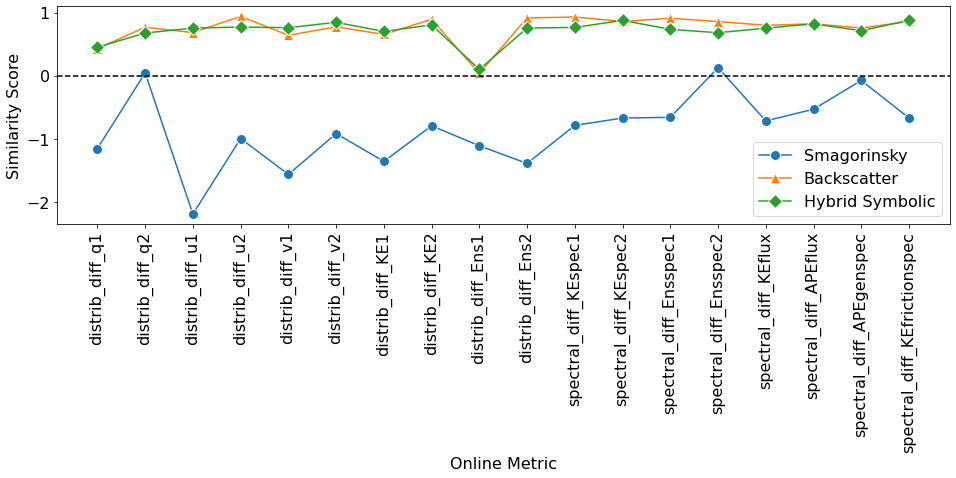

In [29]:
metrics = list(symb_sims.keys())
with plt.rc_context({'font.size': 16}):
    plt.figure(figsize=(16, 4))
    for sims, label, m in [(smag_sims,'Smagorinsky', 'o'),
                        (back_sims,'Backscatter', '^'),
                        (symb_sims,'Hybrid Symbolic', 'D')]:
        plt.plot([sims[k] for k in metrics], label=label,
                 marker=m, markeredgecolor='white', markersize=10)
    plt.legend()
    plt.axhline(0, ls='--', color='black')
    plt.xticks(np.arange(len(metrics)), metrics, rotation=90)
    plt.ylabel("Similarity Score")
    plt.xlabel("Online Metric")
    plt.show()

In [12]:
highres_jet = get_dataset("jet/high_res").load()
lowres_jet = get_dataset("jet/low_res").load()

In [13]:
jet_config = {}
jet_config.update(**pyqg_config)
jet_config['rek'] = lowres_jet.attrs['pyqg:rek']
jet_config['beta'] = lowres_jet.attrs['pyqg:beta']
jet_config['delta'] = lowres_jet.attrs['pyqg:delta']

In [14]:
smagorinsky_jet = Smagorinsky(0.15).run_online(**jet_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 1.80e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.61e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 5.62e-05, CFL: 0.012
INFO: Step: 40000, Time: 1.44e+08, KE: 1.39e-04, CFL: 0.029
INFO: Step: 50000, Time: 1.80e+08, KE: 1.60e-04, CFL: 0.036
INFO: Step: 60000, Time: 2.16e+08, KE: 1.27e-04, CFL: 0.030
INFO: Step: 70000, Time: 2.52e+08, KE: 1.15e-04, CFL: 0.032
INFO: Step: 80000, Time: 2.88e+08, KE: 1.10e-04, CFL: 0.029


In [15]:
backscatter_jet = BackscatterBiharmonic(np.sqrt(0.007), 1.2).run_online(**jet_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 2.50e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 2.10e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 4.44e-05, CFL: 0.011
INFO: Step: 40000, Time: 1.44e+08, KE: 2.32e-04, CFL: 0.038
INFO: Step: 50000, Time: 1.80e+08, KE: 1.85e-04, CFL: 0.039
INFO: Step: 60000, Time: 2.16e+08, KE: 1.79e-04, CFL: 0.045
INFO: Step: 70000, Time: 2.52e+08, KE: 1.96e-04, CFL: 0.039
INFO: Step: 80000, Time: 2.88e+08, KE: 1.80e-04, CFL: 0.039


In [16]:
hybrid_symbolic_jet = HybridSymbolic().run_online(**jet_config)

INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 3.03e-07, CFL: 0.006
INFO: Step: 20000, Time: 7.20e+07, KE: 3.95e-06, CFL: 0.006
INFO: Step: 30000, Time: 1.08e+08, KE: 9.52e-05, CFL: 0.019
INFO: Step: 40000, Time: 1.44e+08, KE: 2.27e-04, CFL: 0.040
INFO: Step: 50000, Time: 1.80e+08, KE: 2.06e-04, CFL: 0.039
INFO: Step: 60000, Time: 2.16e+08, KE: 1.67e-04, CFL: 0.039
INFO: Step: 70000, Time: 2.52e+08, KE: 1.58e-04, CFL: 0.037
INFO: Step: 80000, Time: 2.88e+08, KE: 1.60e-04, CFL: 0.036


In [17]:
smag_sims_jet = ppb.diagnostic_similarities(smagorinsky_jet, target=highres_jet, baseline=lowres_jet)
smag_sims_jet

{'distrib_diff_q1': -0.8441046221883806,
 'distrib_diff_q2': -0.12028116622070062,
 'distrib_diff_u1': -0.8934605167166185,
 'distrib_diff_u2': -1.5196326276753047,
 'distrib_diff_v1': -0.916758326744336,
 'distrib_diff_v2': -0.69392787276553,
 'distrib_diff_KE1': -0.5194406353732297,
 'distrib_diff_KE2': -0.7660377743039373,
 'distrib_diff_Ens1': -0.6042291741105765,
 'distrib_diff_Ens2': -0.7741303807475304,
 'spectral_diff_KEspec1': -0.41192246792282394,
 'spectral_diff_KEspec2': -0.028043794728699112,
 'spectral_diff_Ensspec1': -0.32501011358921517,
 'spectral_diff_Ensspec2': 0.033719594822898324,
 'spectral_diff_KEflux': -1.4796208458039364,
 'spectral_diff_APEflux': -0.29794185526697503,
 'spectral_diff_APEgenspec': -3.05433467527122,
 'spectral_diff_KEfrictionspec': -0.02804388278320258}

In [18]:
back_sims_jet = ppb.diagnostic_similarities(backscatter_jet, target=highres_jet, baseline=lowres_jet)
back_sims_jet

{'distrib_diff_q1': 0.37867721033210966,
 'distrib_diff_q2': -0.24147720174967868,
 'distrib_diff_u1': 0.29595097309028373,
 'distrib_diff_u2': -0.3578784252441518,
 'distrib_diff_v1': 0.24798558006636628,
 'distrib_diff_v2': 0.6536339405264385,
 'distrib_diff_KE1': 0.3272689039838843,
 'distrib_diff_KE2': 0.7670655540422876,
 'distrib_diff_Ens1': -0.027261258726249515,
 'distrib_diff_Ens2': 0.8415810849609231,
 'spectral_diff_KEspec1': 0.5054921365358627,
 'spectral_diff_KEspec2': 0.6304967828557736,
 'spectral_diff_Ensspec1': 0.3890747054485162,
 'spectral_diff_Ensspec2': -1.6689963378822394,
 'spectral_diff_KEflux': -0.3294650315596026,
 'spectral_diff_APEflux': 0.14854163296578038,
 'spectral_diff_APEgenspec': -1.4263009731826166,
 'spectral_diff_KEfrictionspec': 0.6304965999952614}

In [19]:
symb_sims_jet = ppb.diagnostic_similarities(hybrid_symbolic_jet, target=highres_jet, baseline=lowres_jet)
symb_sims_jet

{'distrib_diff_q1': 0.3013357118582074,
 'distrib_diff_q2': 0.8302586893435769,
 'distrib_diff_u1': 0.09539551481215547,
 'distrib_diff_u2': 0.6351608846232737,
 'distrib_diff_v1': 0.21042497458981113,
 'distrib_diff_v2': 0.33641830804437056,
 'distrib_diff_KE1': 0.19187099157476306,
 'distrib_diff_KE2': 0.45323763465048406,
 'distrib_diff_Ens1': 0.008931718246745879,
 'distrib_diff_Ens2': 0.2787261833450858,
 'spectral_diff_KEspec1': 0.7327749047623282,
 'spectral_diff_KEspec2': 0.743159276560581,
 'spectral_diff_Ensspec1': 0.7472454929987318,
 'spectral_diff_Ensspec2': 0.4341378412636606,
 'spectral_diff_KEflux': 0.5116536666971608,
 'spectral_diff_APEflux': 0.3053027457363845,
 'spectral_diff_APEgenspec': -0.23880148223531794,
 'spectral_diff_KEfrictionspec': 0.7431593768535658}

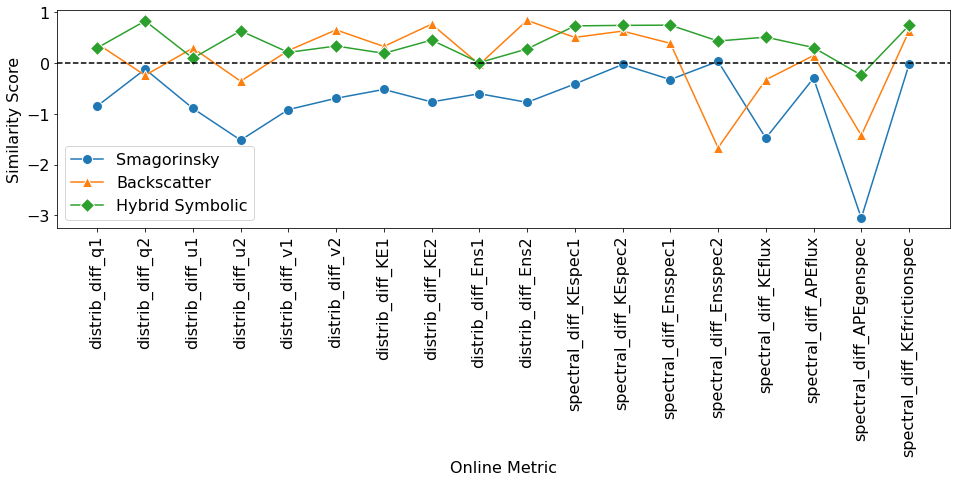

In [28]:
metrics = list(symb_sims.keys())
with plt.rc_context({'font.size': 16}):
    plt.figure(figsize=(16, 4))
    for sims, label, m in [(smag_sims_jet,'Smagorinsky', 'o'),
                        (back_sims_jet,'Backscatter', '^'),
                        (symb_sims_jet,'Hybrid Symbolic', 'D')]:
        plt.plot([sims[k] for k in metrics], label=label,
                 marker=m, markeredgecolor='white', markersize=10)
    plt.legend()
    plt.axhline(0, ls='--', color='black')
    plt.xticks(np.arange(len(metrics)), metrics, rotation=90)
    plt.ylabel("Similarity Score")
    plt.xlabel("Online Metric")
    plt.show()